**Closed Loop Errors Demo**

Make sure the ERA5 Wind Data is downloaded from the following link:
https://drive.google.com/file/d/1Y5ocrCH0TVf9ZDkVGaJ03ftUrtKEVxIf/view?usp=sharing

Make sure it's saved into your Google Drive (in the main drive, not within a subfolder).

# **Installations**

In [ ]:
!git clone https://github.com/sdean-group/balloon-outreach.git
%cd balloon-outreach
!git checkout main

Cloning into 'balloon-outreach'...
remote: Enumerating objects: 1063, done.
remote: Counting objects: 100% (311/311), done.
remote: Compressing objects: 100% (173/173), done.
remote: Total 1063 (delta 191), reused 194 (delta 137), pack-reused 752 (from 2)
Receiving objects: 100% (1063/1063), 112.22 MiB | 15.26 MiB/s, done.
Resolving deltas: 100% (635/635), done.
/content/balloon-outreach
Already on 'v0'
Your branch is up to date with 'origin/v0'.


In [2]:
# Install required packages
!pip install -r requirements.txt
!pip install -U gdown

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.0/268.0 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.7 MB/s eta 0:00:00
   ━━━━━━

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import sys
sys.path.append('/content/balloon-outreach/')

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from math import cos, radians
from datetime import datetime
from env.ERA_wind_field import WindField


datapath = "/content/drive/MyDrive/era5_data.nc"

In [5]:
# Ensure download worked
ds = xr.open_dataset(datapath, engine='netcdf4')
print(ds)

<xarray.Dataset> Size: 3GB
Dimensions:         (valid_time: 120, pressure_level: 7, latitude: 361,
                     longitude: 1440)
Coordinates:
    number          int64 8B ...
  * valid_time      (valid_time) datetime64[ns] 960B 2024-07-01 ... 2024-07-0...
  * pressure_level  (pressure_level) float64 56B 1e+03 800.0 ... 200.0 100.0
  * latitude        (latitude) float64 3kB 90.0 89.75 89.5 ... 0.5 0.25 0.0
  * longitude       (longitude) float64 12kB -180.0 -179.8 ... 179.5 179.8
    expver          (valid_time) <U4 2kB ...
Data variables:
    u               (valid_time, pressure_level, latitude, longitude) float32 2GB ...
    v               (valid_time, pressure_level, latitude, longitude) float32 2GB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
  

# **Generating Tree Search Actions**

*WindField with no noise*

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import datetime as dt
from env.balloon_env import BalloonERAEnvironment
from env.balloon import Balloon, WindVector
from agent.tree_search_agent import run_astar_fly_as_far_as_possible, DiscretizeConfig

# ------PARAMETERS---------
initial_lat, initial_lon = 42.6, -76.5 #deg
initial_alt = 10.0 #km
initial_volume = 1000.0  # Initial volume (m³)
initial_sand = 100  # Initial sand mass (kg)
start_time_np = ds.valid_time.values[0]
start_time = pd.to_datetime(start_time_np).to_pydatetime()
duration_seconds = 24*3600
dt_seconds = 60
n_steps = int(duration_seconds / dt_seconds)
wf = WindField(ds, start_time=start_time,add_noise=False)



# For visualization
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)

# Configuration parameters
use_simplified_step = True  # Use simplified step for A* search
lat_long_atol = 1e-1        # Tolerance for latitude and longitude (degrees)
alt_atol = 1                # Tolerance for altitude (km)
environment_step = 1200     # Environment step (s)
max_iter = 2000           # Maximum iterations for A* search
max_depth = 10            # Maximum depth for A* search (in discrete timesteps) - None means no limit.
discretization_config = DiscretizeConfig(use_discretization=True, decimals=1)

np.random.seed(0)  # For reproducible results
#-----------------------------

WindField initialized with noise enabled: False


WindField initialized with noise enabled: False
Discretized initial state: [ 42.6 -76.5  10.    0. ]
Iteration 1/1000
Iteration 2/1000
Iteration 3/1000
Iteration 4/1000
Iteration 5/1000
Iteration 6/1000
Iteration 7/1000
Iteration 8/1000
Iteration 9/1000
Iteration 10/1000
Iteration 11/1000
Iteration 12/1000
Iteration 13/1000
Iteration 14/1000
Iteration 15/1000
Iteration 16/1000
Iteration 17/1000
Iteration 18/1000
Iteration 19/1000
Iteration 20/1000
Iteration 21/1000
Iteration 22/1000
Iteration 23/1000
Iteration 24/1000
Iteration 25/1000
Iteration 26/1000
Iteration 27/1000
Iteration 28/1000
Iteration 29/1000
Iteration 30/1000
Iteration 31/1000
Iteration 32/1000
Iteration 33/1000
Iteration 34/1000
Iteration 35/1000
Iteration 36/1000
Iteration 37/1000
Iteration 38/1000
Iteration 39/1000
Iteration 40/1000
Iteration 41/1000
Iteration 42/1000
Iteration 43/1000
Iteration 44/1000
Iteration 45/1000
Iteration 46/1000
Iteration 47/1000
Iteration 48/1000
Iteration 49/1000
Iteration 50/1000
Iteratio

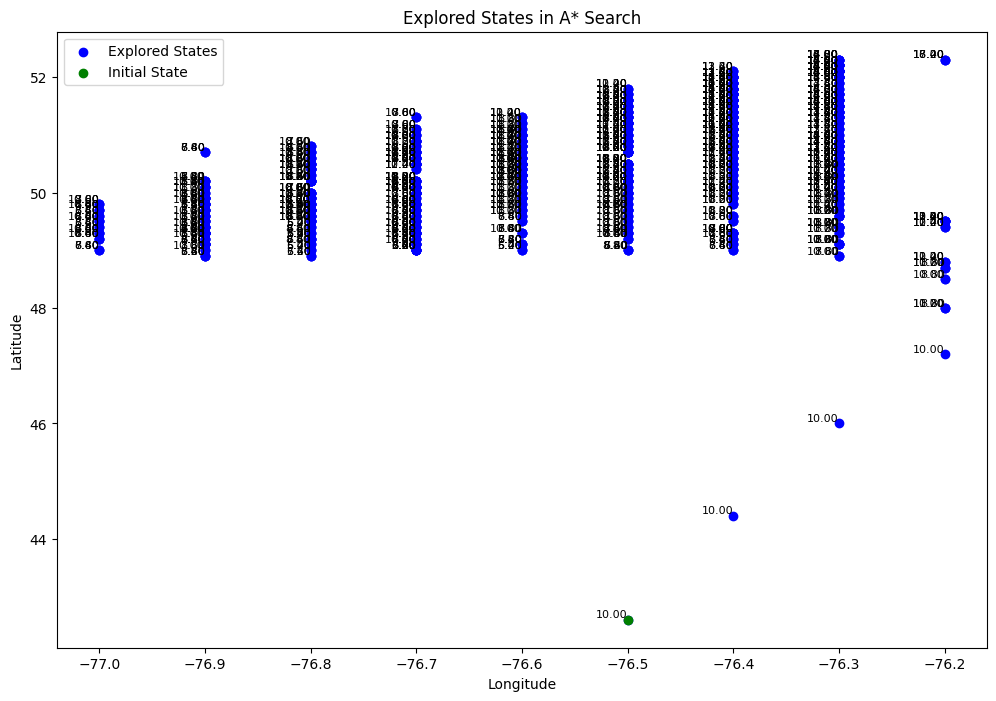

Action sequence (flying as far as possible): [((np.float64(42.6), np.float64(-76.5), np.float64(10.0), np.float64(0.0)), 'stay'), ((np.float64(44.4), np.float64(-76.4), np.float64(10.0), np.float64(0.3)), 'stay'), ((np.float64(46.0), np.float64(-76.3), np.float64(10.0), np.float64(0.7)), 'stay'), ((np.float64(47.2), np.float64(-76.2), np.float64(10.0), np.float64(1.0)), 'ascend'), ((np.float64(48.0), np.float64(-76.2), np.float64(11.2), np.float64(1.3)), 'ascend'), ((np.float64(48.8), np.float64(-76.2), np.float64(12.4), np.float64(1.7)), 'ascend'), ((np.float64(49.5), np.float64(-76.2), np.float64(13.6), np.float64(2.0)), 'ascend'), ((np.float64(50.2), np.float64(-76.3), np.float64(14.8), np.float64(2.3)), 'ascend'), ((np.float64(50.9), np.float64(-76.3), np.float64(16.0), np.float64(2.7)), 'ascend'), ((np.float64(51.7), np.float64(-76.3), np.float64(17.2), np.float64(3.0)), 'stay'), ((np.float64(52.3), np.float64(-76.2), np.float64(17.2), np.float64(3.3)), None)]
Found path with 11 s

<Figure size 1200x800 with 0 Axes>

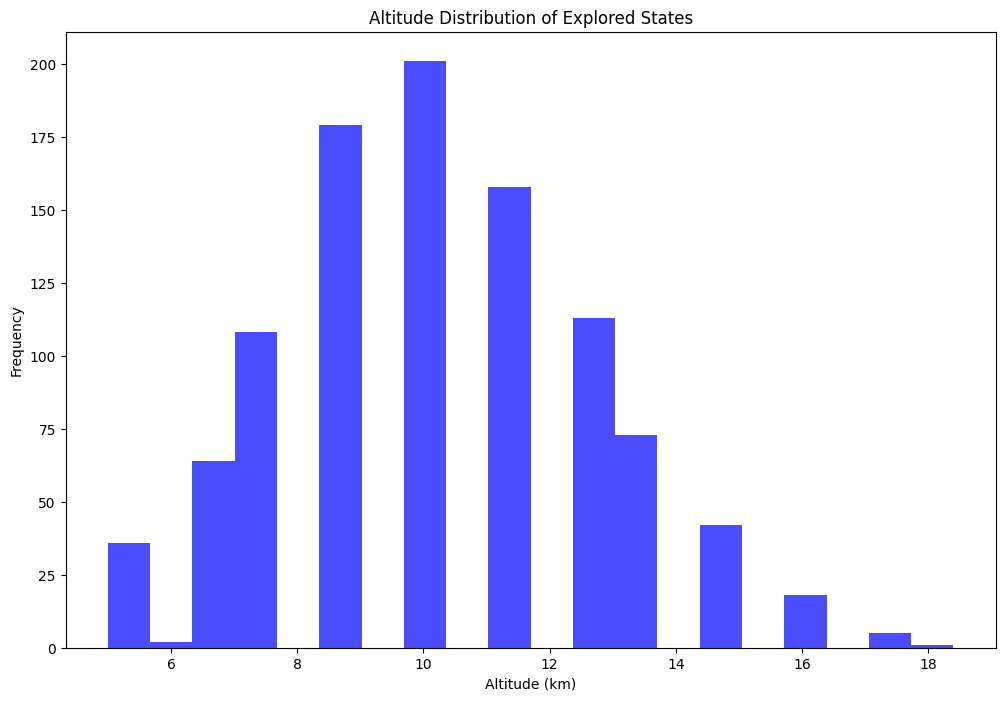

In [9]:
# BalloonERAEnvironment initialization
start_time = dt.datetime(2024, 7, 1, 0, 0)
env = BalloonERAEnvironment(initial_lat=42.6, initial_lon=-76.5, initial_alt=10.0, target_lat= 58, target_lon=-76, target_alt=10, ds=ds, start_time=start_time, viz=False, add_noise=False, dt=environment_step)
initial_state = env.get_balloon_state()  # Get the initial state of the balloon
start_state = np.array([42.6, -76.5, 10.0])

env.set_balloon_state(initial_state)
optimal_path = run_astar_fly_as_far_as_possible(env, initial_lat=start_state[0], initial_long=start_state[1], initial_alt=start_state[2],
            plot_suffix="test_era_notebook", simplified_step=True,
            max_iter=max_iter, max_depth=max_depth, discretize_config=discretization_config)

if optimal_path:
    print(f"Found path with {len(optimal_path)} steps")
else:
    print("No path found within iteration limit")


tree_actions = []
for info, action in optimal_path:
  if action == 'stay':
    tree_actions.append(0.0)
  elif action == 'descend':
    tree_actions.append(-1.0)
  else:
    tree_actions.append(1.0)

tree_trajectory = []
for state in (optimal_path):
  tree_trajectory.append(state[0][:3])

WindField with noise:

WindField initialized with noise enabled: True
Discretized initial state: [ 42.6 -76.5  10.    0. ]
Iteration 1/1000
Iteration 2/1000
Iteration 3/1000
Iteration 4/1000
Iteration 5/1000
Iteration 6/1000
Iteration 7/1000
Iteration 8/1000
Iteration 9/1000
Iteration 10/1000
Iteration 11/1000
Iteration 12/1000
Iteration 13/1000
Iteration 14/1000
Iteration 15/1000
Iteration 16/1000
Iteration 17/1000
Iteration 18/1000
Iteration 19/1000
Iteration 20/1000
Iteration 21/1000
Iteration 22/1000
Iteration 23/1000
Iteration 24/1000
Iteration 25/1000
Iteration 26/1000
Iteration 27/1000
Iteration 28/1000
Iteration 29/1000
Iteration 30/1000
Iteration 31/1000
Iteration 32/1000
Iteration 33/1000
Iteration 34/1000
Iteration 35/1000
Iteration 36/1000
Iteration 37/1000
Iteration 38/1000
Iteration 39/1000
Iteration 40/1000
Iteration 41/1000
Iteration 42/1000
Iteration 43/1000
Iteration 44/1000
Iteration 45/1000
Iteration 46/1000
Iteration 47/1000
Iteration 48/1000
Iteration 49/1000
Iteration 50/1000
Iteration

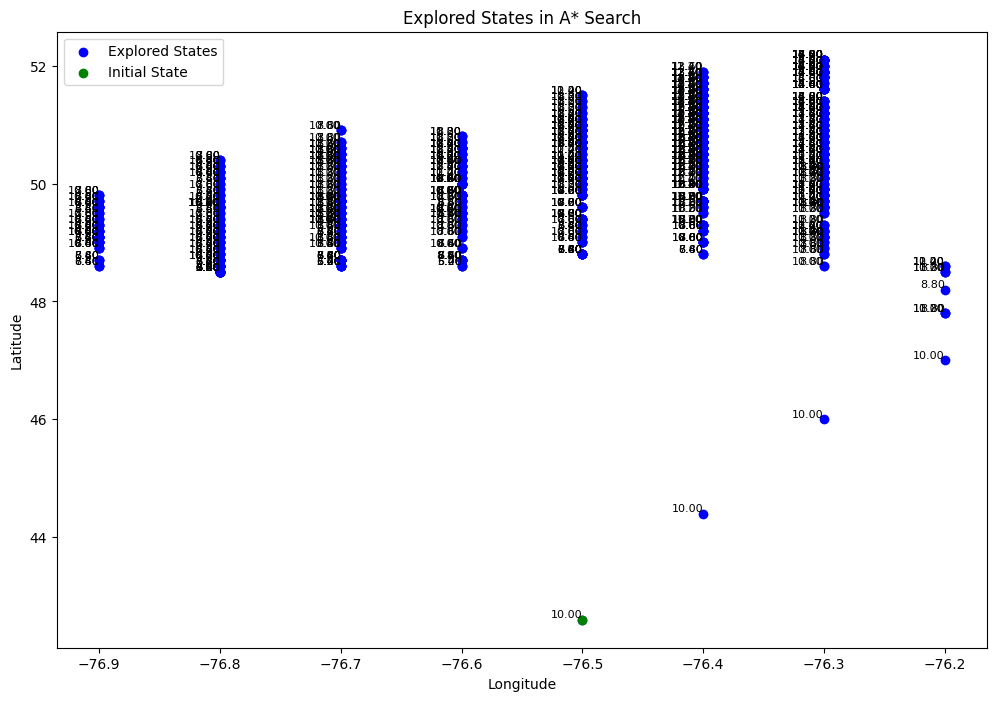

Action sequence (flying as far as possible): [((np.float64(42.6), np.float64(-76.5), np.float64(10.0), np.float64(0.0)), 'stay'), ((np.float64(44.4), np.float64(-76.4), np.float64(10.0), np.float64(0.3)), 'stay'), ((np.float64(46.0), np.float64(-76.3), np.float64(10.0), np.float64(0.7)), 'stay'), ((np.float64(47.0), np.float64(-76.2), np.float64(10.0), np.float64(1.0)), 'ascend'), ((np.float64(47.8), np.float64(-76.2), np.float64(11.2), np.float64(1.3)), 'ascend'), ((np.float64(48.6), np.float64(-76.2), np.float64(12.4), np.float64(1.7)), 'ascend'), ((np.float64(49.2), np.float64(-76.3), np.float64(13.6), np.float64(2.0)), 'ascend'), ((np.float64(49.9), np.float64(-76.3), np.float64(14.8), np.float64(2.3)), 'ascend'), ((np.float64(50.7), np.float64(-76.3), np.float64(16.0), np.float64(2.7)), 'ascend'), ((np.float64(51.4), np.float64(-76.3), np.float64(17.2), np.float64(3.0)), 'descend'), ((np.float64(52.1), np.float64(-76.3), np.float64(16.0), np.float64(3.3)), None)]
Found path with 1

<Figure size 1200x800 with 0 Axes>

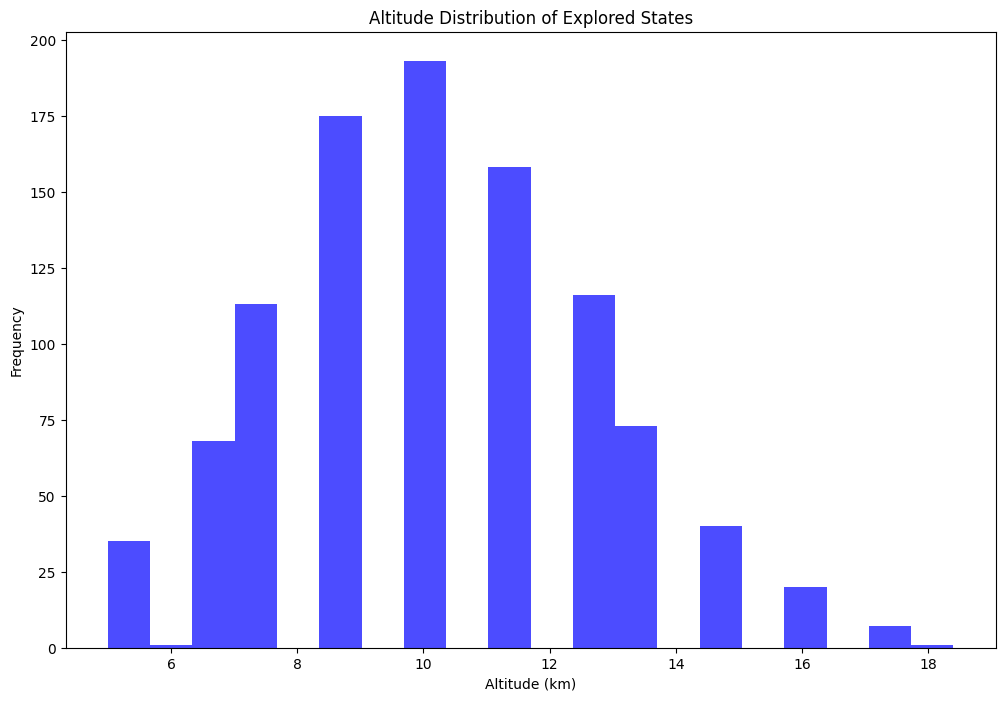

In [10]:
# BalloonERAEnvironment initialization
start_time = dt.datetime(2024, 7, 1, 0, 0)
env = BalloonERAEnvironment(initial_lat=42.6, initial_lon=-76.5, initial_alt=10.0, target_lat= 58, target_lon=-76, target_alt=10, ds=ds, start_time=start_time, viz=False, add_noise=True, dt=environment_step)
initial_state = env.get_balloon_state()  # Get the initial state of the balloon
start_state = np.array([42.6, -76.5, 10.0])
target_state = np.array([58, -76, 10])  # lat, lon, alt

env.set_balloon_state(initial_state)
optimal_path = run_astar_fly_as_far_as_possible(env, initial_lat=start_state[0], initial_long=start_state[1], initial_alt=start_state[2],
            plot_suffix="test_era_notebook", simplified_step=True,
            max_iter=max_iter, max_depth=max_depth, discretize_config=discretization_config)

if optimal_path:
    print(f"Found path with {len(optimal_path)} steps")
else:
    print("No path found within iteration limit")

tree_wind_actions = []
for info, action in optimal_path:
  if action == 'stay':
    tree_wind_actions.append(0.0)
  elif action == 'descend':
    tree_wind_actions.append(-1.0)
  else:
    tree_wind_actions.append(1.0)


tree_wind_trajectory = []
for state in (optimal_path):
  tree_wind_trajectory.append(state[0][:3])

Tree search no noise wind action sequence: [0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0]
Tree search with simplex wind action sequence: [0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, 1.0]


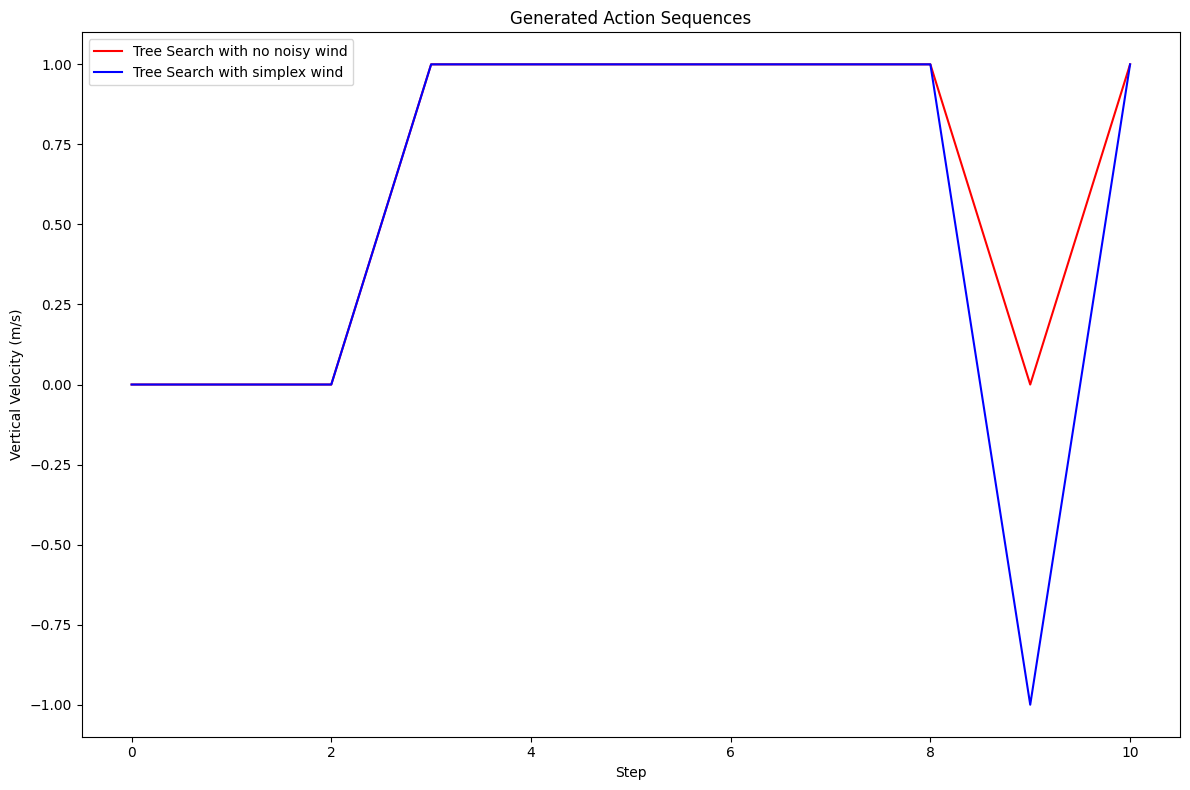

In [11]:
print(f"Tree search no noise wind action sequence: {tree_actions}")
print(f"Tree search with simplex wind action sequence: {tree_wind_actions}")
plt.plot([i for i in range(len(tree_actions))], tree_actions, 'r-', label='Tree Search with no noisy wind')
plt.plot([i for i in range(len(tree_wind_actions))], tree_wind_actions, 'b-', label='Tree Search with simplex wind')
plt.title(f'Generated Action Sequences')
plt.xlabel('Step')
plt.ylabel('Vertical Velocity (m/s)')
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

# **Plot Balloon Trajectory with Tree Search Actions**

In [12]:
def plot_pressure(pressure_profile):
  # Plotting pressure kevel over time
  plt.plot(pressure_profile, 'b-')
  plt.grid(True)
  plt.title(f'Pressure Profile')
  plt.xlabel('Time Step')
  plt.ylabel('Pressure (hPa)')

  plt.tight_layout()
  plt.show()
  plt.savefig('balloon_altitude.png')
  plt.close()

def plot_resources(actions, velocities, helium_mass, sands):
  # Plotting the intended velocity vs actual velocity and resource usage over time
  plt.figure(figsize=(12, 4))

  # (1) Target velocity (action) vs. Current velocity
  plt.subplot(1, 2, 1)
  plt.plot(actions, label='Target velocity (action)')
  plt.plot(velocities, label='Current vertical velocity')
  plt.xlabel('Step')
  plt.ylabel('Velocity (m/s)')
  plt.title('Target vs. Current Vertical Velocity')
  plt.legend()
  plt.grid(True)

  # (2) Resource (volume, sand)
  plt.subplot(1, 2, 2)
  plt.plot(helium_mass, label='Helium Mass')
  plt.plot(sands, label='Sand')
  plt.xlabel('Step')
  plt.ylabel('Resource')
  plt.title('Resource Change')
  plt.legend()
  plt.grid(True)

  plt.tight_layout()
  plt.show()
  plt.savefig('balloon_velocity_and_resource.png')
  plt.close()

In [13]:
# Plots the trajectory on a map given an action list - credit to ERA5 Wind Field notebook
def get_trajectory_info(env, n_steps, dt_seconds, action_list, action_type:str):
    env.balloon.vertical_velocity = 0.0
    pressure_profile = []
    latitudes = []
    longitudes = []
    helium_masses = []
    sand_masses = []
    velocities = []

    pressure_profile.append(env.balloon.altitude_to_pressure(env.balloon.alt * 1000))
    latitudes.append(env.balloon.lat)
    longitudes.append(env.balloon.lon)
    velocities.append(env.balloon.vertical_velocity)
    helium_masses.append(env.balloon.helium_mass)
    sand_masses.append(env.balloon.sand)




    # Run simulation
    for i in range(n_steps):
        state, _, _, _ = env.step(action_list[i])

        pressure_profile.append(env.balloon.altitude_to_pressure(env.balloon.alt * 1000))
        latitudes.append(env.balloon.lat)
        longitudes.append(env.balloon.lon)
        helium_masses.append(env.balloon.helium_mass)
        sand_masses.append(env.balloon.sand)
        velocities.append(env.balloon.vertical_velocity)

    fig, ax = plt.subplots(
        figsize=(12,6),
        subplot_kw={'projection': ccrs.PlateCarree()}
    )

    # around the North America
    ax.set_extent([-180,0,0,90], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
    ax.coastlines('50m', linewidth=0.5)

    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    gl.top_labels = False; gl.right_labels = False

    # 1) Plot the trajectory line in grey
    ax.plot(longitudes, latitudes,
            transform=ccrs.PlateCarree(),
            color='blue', linewidth=1)

    # 3) Start/end markers
    ax.scatter(longitudes[0], latitudes[0],
              transform=ccrs.PlateCarree(),
              color='green', marker='o', s=80,
              label='Start')
    ax.scatter(longitudes[-1], latitudes[-1],
              transform=ccrs.PlateCarree(),
              color='red', marker='X', s=80,
              label='End')

    ax.set_title("Balloon Trajectory with " + action_type + " Actions")
    ax.set_xlabel("Longitude (°E)")
    ax.set_ylabel("Latitude (°N)")
    ax.legend(loc='lower left')

    plt.show()
    return pressure_profile, velocities, helium_masses, sand_masses

Compare the differences between the two trajectories below:

Without Noisy WindField:

WindField initialized with noise enabled: False


/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


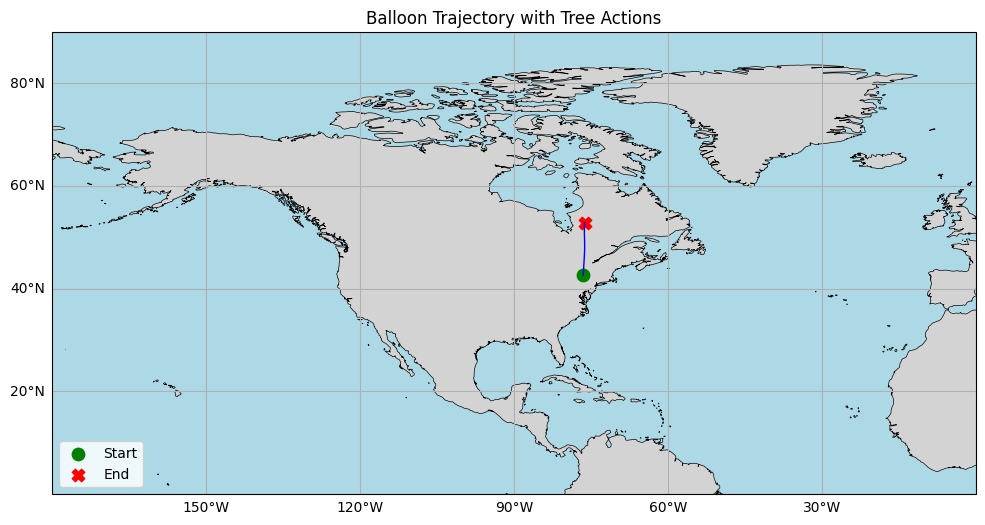

In [15]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

env = BalloonERAEnvironment(initial_lat=42.6, initial_lon=-76.5, initial_alt=10.0, target_lat= 58, target_lon=-76, target_alt=10, ds=ds, start_time=start_time, viz=False, add_noise=False, dt=environment_step)
pressure_profile, velocities, helium_masses, sand_masses = get_trajectory_info(env, len(tree_actions), env.dt, tree_actions, 'Tree')

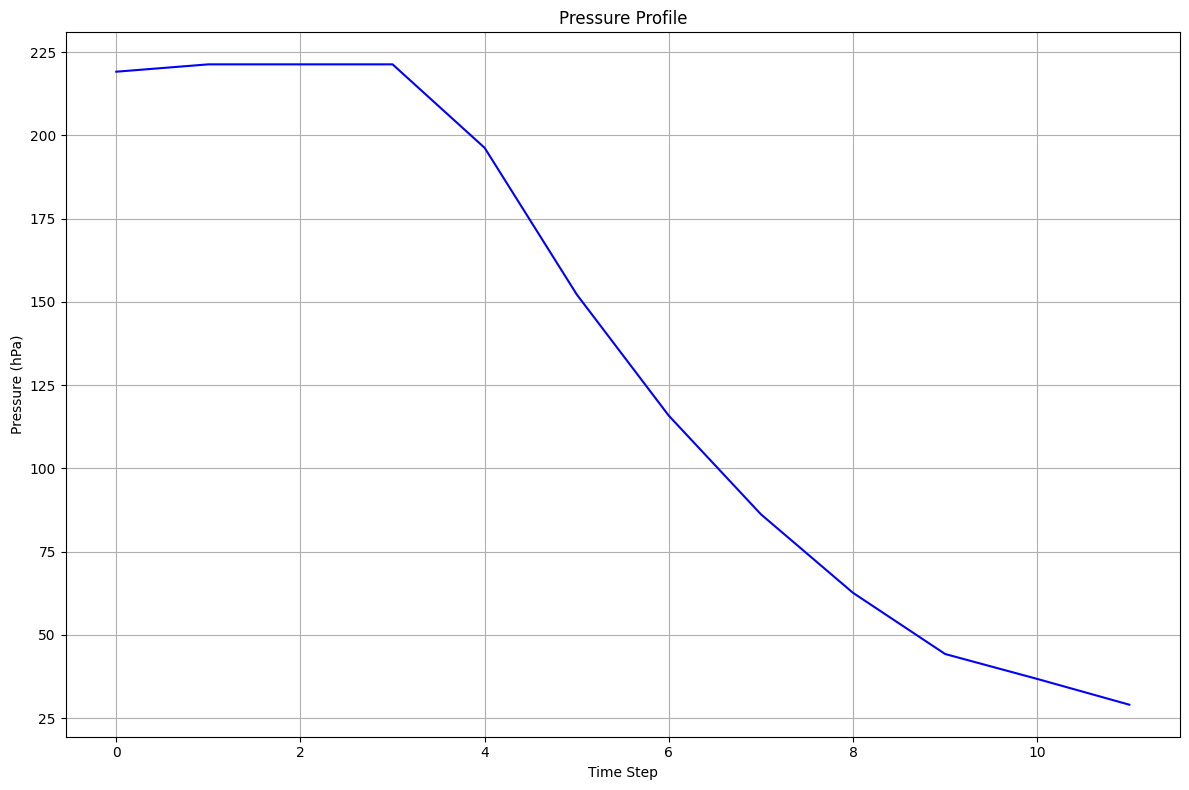

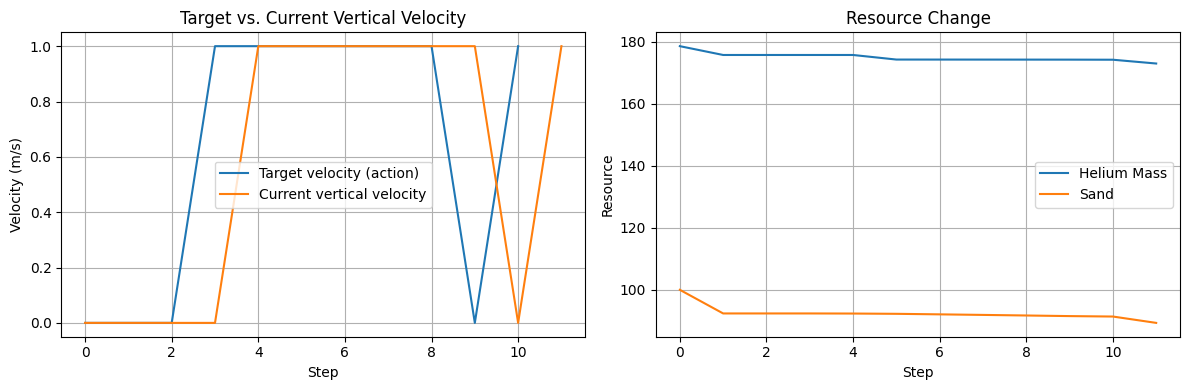

In [16]:
plot_pressure(pressure_profile)
plot_resources(tree_actions, velocities, helium_masses, sand_masses)

With Noisy WindField:

WindField initialized with noise enabled: True


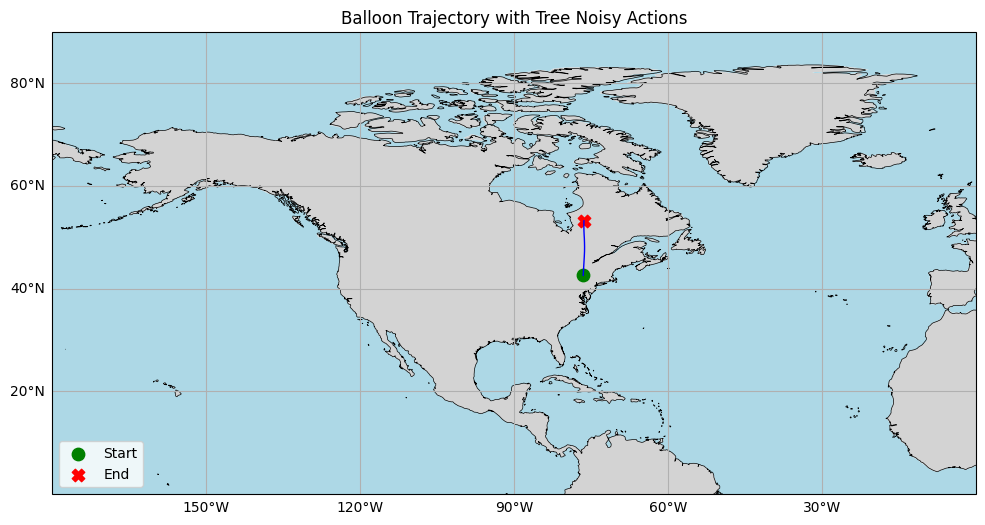

In [17]:
env = BalloonERAEnvironment(initial_lat=42.6, initial_lon=-76.5, initial_alt=10.0, target_lat= 58, target_lon=-76, target_alt=10, ds=ds, start_time=start_time, viz=False, add_noise=True, dt=environment_step)
pressure_profile, velocities, helium_masses, sand_masses = get_trajectory_info(env, len(tree_actions), env.dt, tree_wind_actions, 'Tree Noisy')

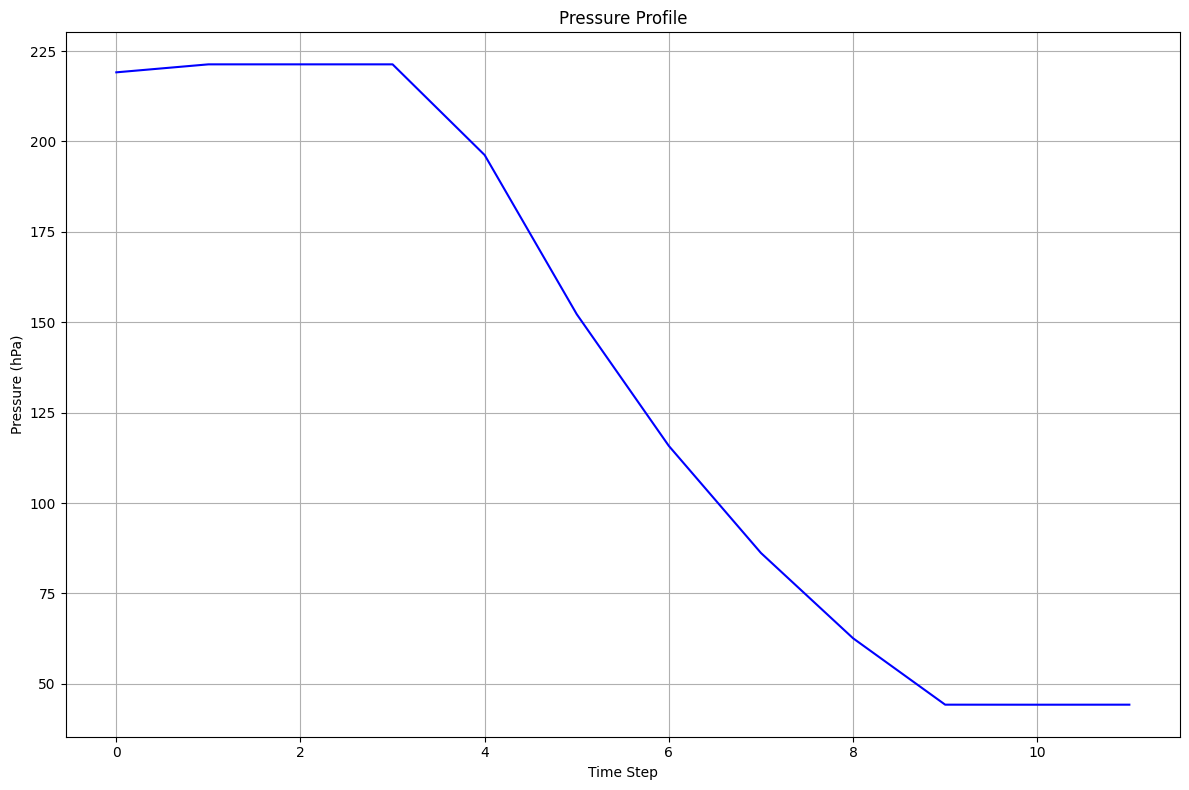

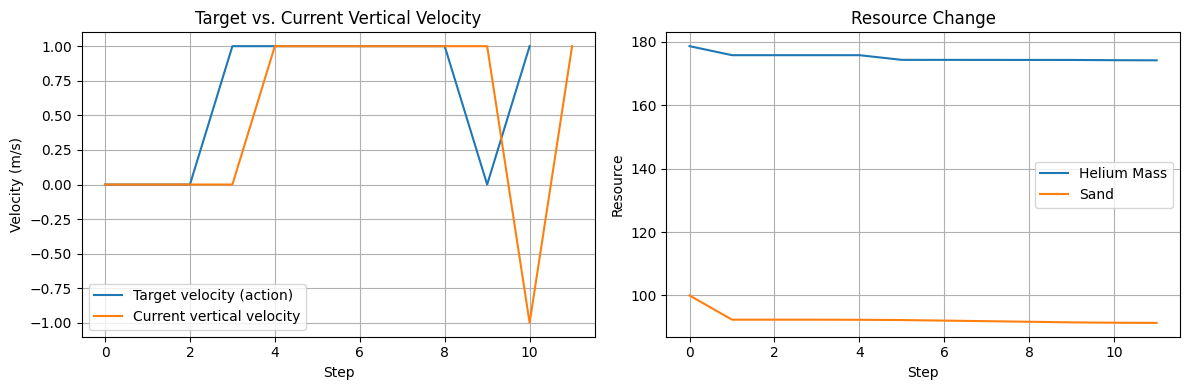

In [18]:
plot_pressure(pressure_profile)
plot_resources(tree_actions, velocities, helium_masses, sand_masses)

Globe Trajectory Visualizations

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import importlib.resources as pkg_resources
from pathlib import Path
from env.visualize import plot_trajectory_earth

# Robustly locate the texture image. Works for both namespace packages and local runs.
try:
    texture_path = pkg_resources.files("env").joinpath("figs/2k_earth_daymap.jpg")
except Exception:
    texture_path = Path(__file__).resolve().parent / "env" / "figs" / "2k_earth_daymap.jpg"

lats, lons, altitudes = zip(*tree_trajectory)

print("Without wind noise")
try:
    plot_trajectory_earth(
        lats,
        lons,
        altitudes,
        texture_path=str(texture_path),
        lon_offset_deg=210,
        flip_lat=True,
    )
except Exception as e:
    print(f"Plotly 3D visualization failed: {e}")


In [ ]:
print('With wind noise')
lats_noise, lons_noise, altitudes_noise = zip(*tree_wind_trajectory)
plot_trajectory_earth(
        lats_noise,
        lons_noise,
        altitudes_noise,
        texture_path=str(texture_path),
        lon_offset_deg=210,
        flip_lat=True,
    )

# **Generating Actions using Iterative Optimization**

This section takes a little longer to run. Note: If your computer gets noticeably slower, clear the above outputs as the Globe visualizations might use a lot of resources.

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import datetime as dt
from env.balloon_env import BalloonERAEnvironment
from env.balloon import Balloon, WindVector
from agent.mppi_agent import MPPIAgent

# ------PARAMETERS---------
initial_lat, initial_lon = 42.6, -76.5 #deg
initial_alt = 10.0 #km
initial_volume = 1000.0  # Initial volume (m³)
initial_sand = 100  # Initial sand mass (kg)
start_time_np = ds.valid_time.values[0]
start_time = pd.to_datetime(start_time_np).to_pydatetime()
duration_seconds = 24*3600
dt_seconds = 300
n_steps = int(duration_seconds / dt_seconds)
n_steps=10
# For visualization
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)

np.random.seed(0)  # For reproducible results
#-----------------------------


In [22]:
# Run the agent without the noisy wind field
start_time = dt.datetime(2024, 7, 1, 0, 0)
env = BalloonERAEnvironment(initial_lat=initial_lat, initial_lon=initial_lon, initial_alt=initial_alt, objective='fly', ds=ds, start_time=start_time, viz=False, add_noise=False, dt=dt_seconds)
agent= MPPIAgent(horizon=5, objective='fly') # horizon is low for computation time, so differences might not be as evident
state = env.reset()
opt_actions = []


env.balloon.vertical_velocity = 0.0
pressure_profile = []
latitudes = []
longitudes = []
altitudes = []
helium_masses = []
sand_masses = []
velocities = []

pressure_profile.append(env.balloon.altitude_to_pressure(env.balloon.alt * 1000))
latitudes.append(env.balloon.lat)
longitudes.append(env.balloon.lon)
altitudes.append(env.balloon.alt)
velocities.append(env.balloon.vertical_velocity)
helium_masses.append(env.balloon.helium_mass)
sand_masses.append(env.balloon.sand)

for step in range(n_steps):
  action = agent.select_action(state, env, step)
  opt_actions.append(action)
  state, _, done, _ = env.step(action)
  pressure_profile.append(env.balloon.altitude_to_pressure(env.balloon.alt * 1000))
  latitudes.append(env.balloon.lat)
  longitudes.append(env.balloon.lon)
  altitudes.append(env.balloon.alt)
  helium_masses.append(env.balloon.helium_mass)
  sand_masses.append(env.balloon.sand)
  velocities.append(env.balloon.vertical_velocity)
  if done:
    print(f"Terminated")
    break
  print(f"On step {step}")



WindField initialized with noise enabled: False
On step 0
On step 1
On step 2
On step 3
On step 4
On step 5
On step 6
On step 7
On step 8
On step 9


In [ ]:
plot_trajectory_earth(latitudes, longitudes, altitudes,texture_path=str(texture_path),lon_offset_deg=210,flip_lat=True)

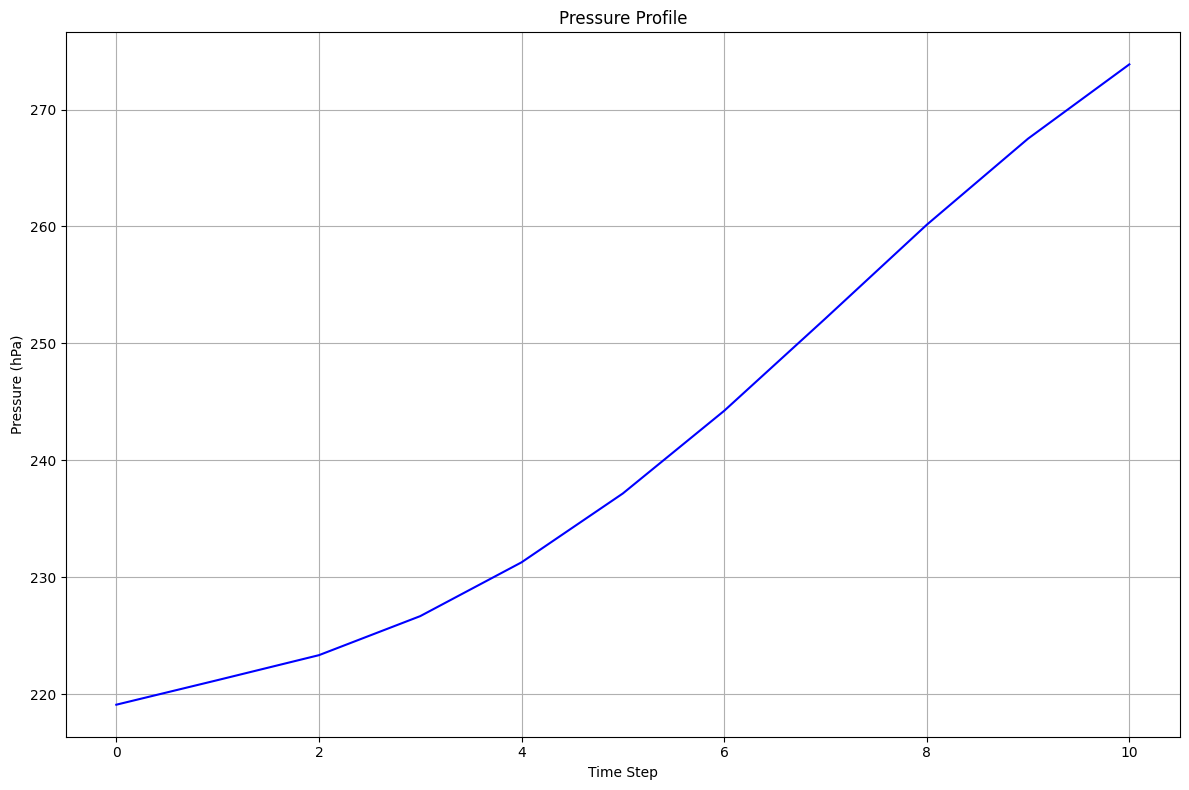

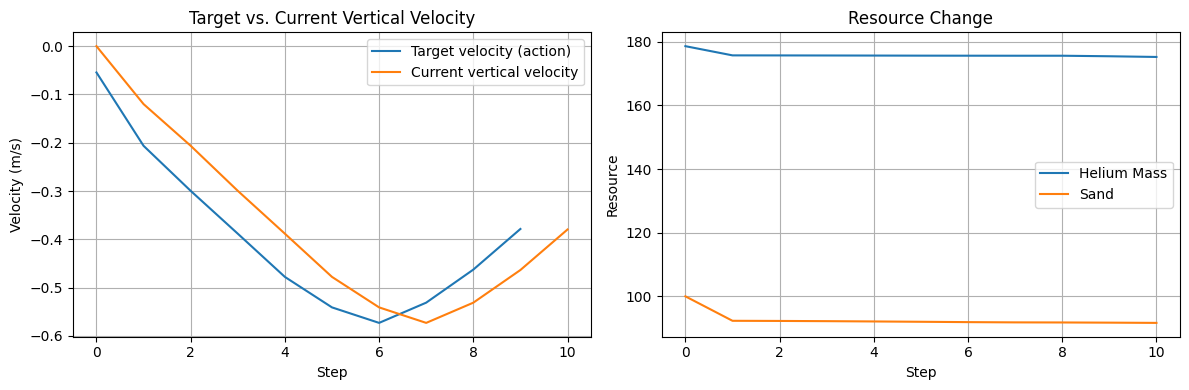

In [24]:
plot_pressure(pressure_profile)
plot_resources(opt_actions, velocities, helium_masses, sand_masses)

In [25]:
# Run the agent on the noisy wind field
env_noise =  BalloonERAEnvironment(initial_lat=initial_lat, initial_lon=initial_lon, initial_alt=initial_alt, objective='fly', ds=ds, start_time=start_time, viz=False, add_noise=True, dt=dt_seconds)
noise_agent = MPPIAgent(horizon=5, objective='fly')
state = env.reset()
state_noise = env_noise.reset()

opt_noise_actions = []
env_noise.balloon.vertical_velocity = 0.0
pressure_profile = []
latitudes = []
longitudes = []
helium_masses = []
sand_masses = []
velocities = []

pressure_profile.append(env_noise.balloon.altitude_to_pressure(env_noise.balloon.alt * 1000))
latitudes.append(env_noise.balloon.lat)
longitudes.append(env_noise.balloon.lon)
velocities.append(env_noise.balloon.vertical_velocity)
helium_masses.append(env_noise.balloon.helium_mass)
sand_masses.append(env_noise.balloon.sand)
for step in range(n_steps):
  action_noise = noise_agent.select_action(state_noise, env_noise, step)
  opt_noise_actions.append(action_noise)
  state_noise,_, done_noise, _ = env_noise.step(action_noise)
  pressure_profile.append(env_noise.balloon.altitude_to_pressure(env_noise.balloon.alt * 1000))
  latitudes.append(env_noise.balloon.lat)
  longitudes.append(env_noise.balloon.lon)
  helium_masses.append(env_noise.balloon.helium_mass)
  sand_masses.append(env_noise.balloon.sand)
  velocities.append(env_noise.balloon.vertical_velocity)
  if done_noise:
    print(f"Terminated")
    break
  print(f"On step {step}")


WindField initialized with noise enabled: True
On step 0
On step 1
On step 2
On step 3
On step 4
On step 5
On step 6
On step 7
On step 8
On step 9


In [ ]:
plot_trajectory_earth(latitudes, longitudes, altitudes,texture_path=str(texture_path),lon_offset_deg=210,flip_lat=True)

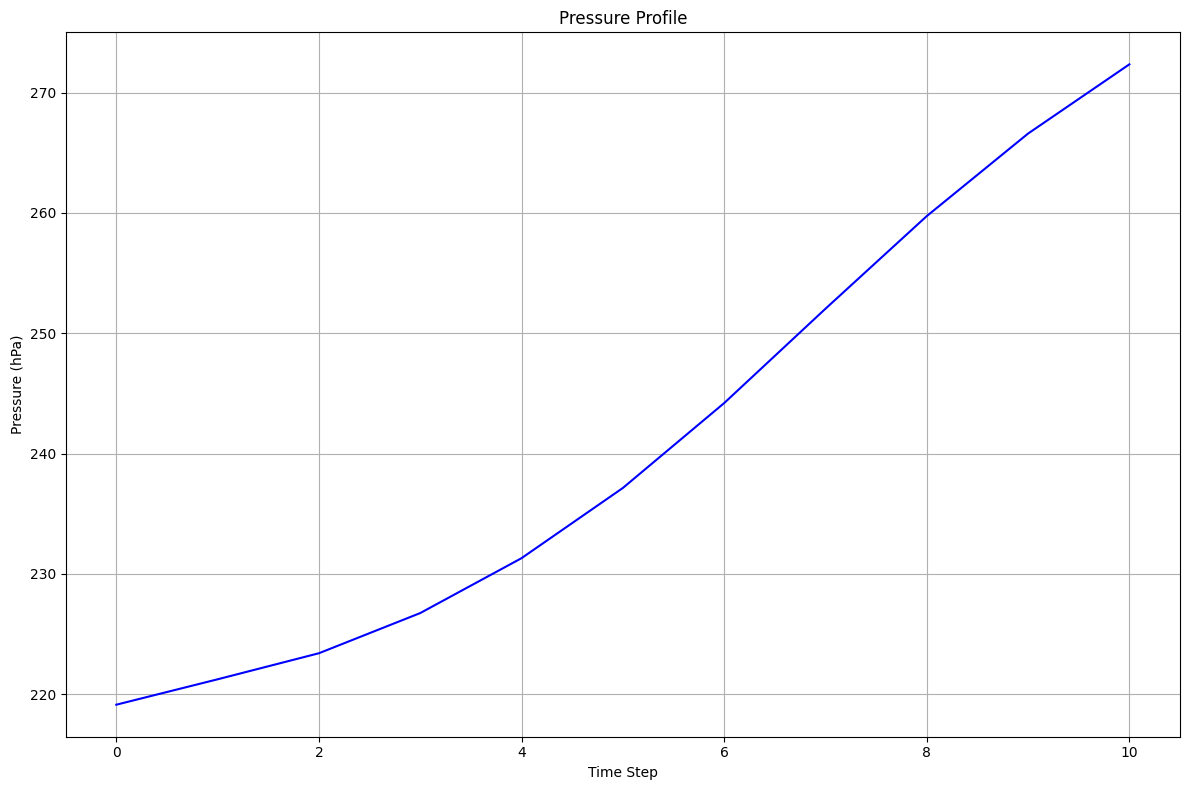

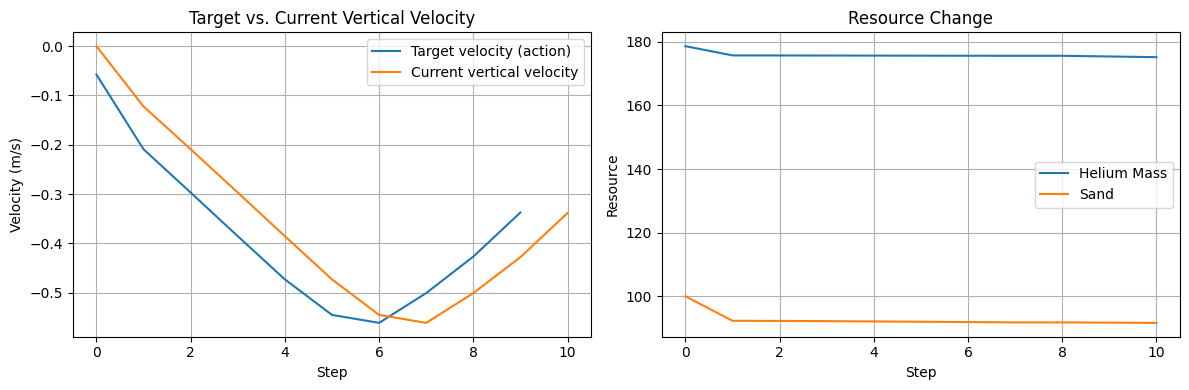

In [27]:
plot_pressure(pressure_profile)
plot_resources(opt_noise_actions, velocities, helium_masses, sand_masses)

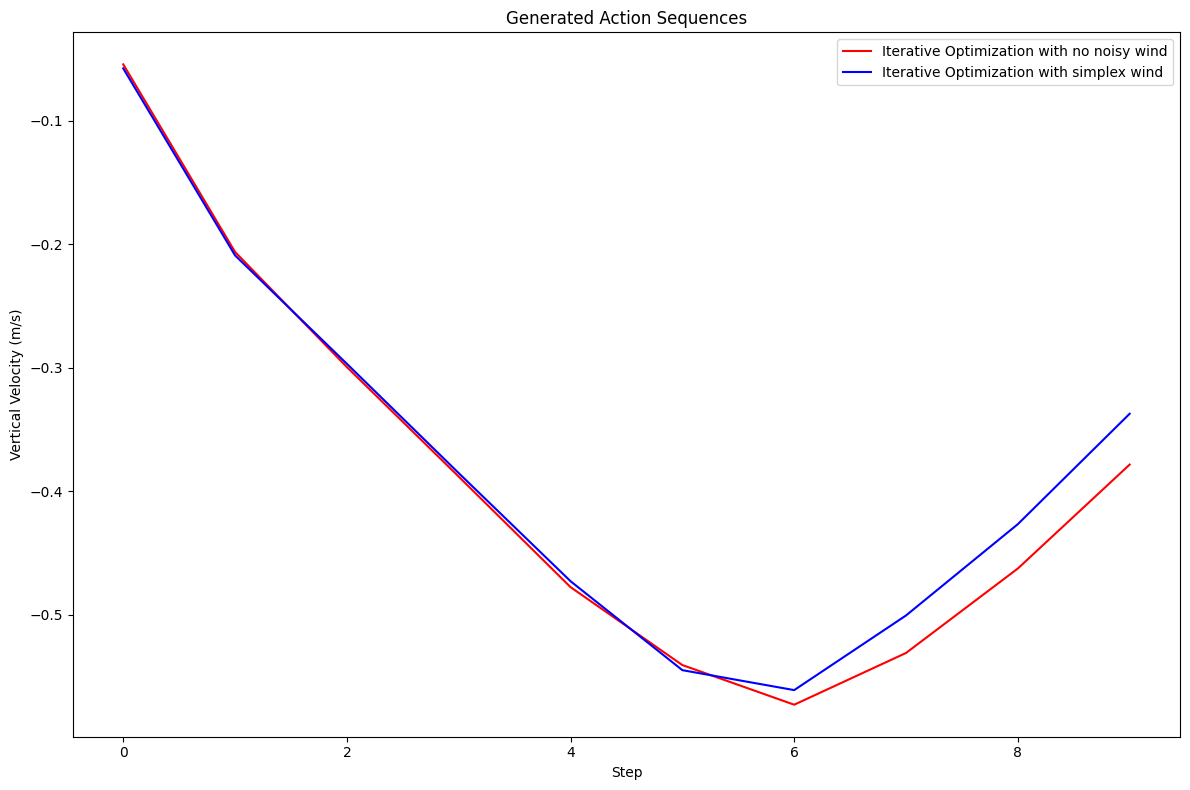

In [29]:
# Graph showing action sequences
plt.plot(opt_actions, 'r-', label='Iterative Optimization with no noisy wind')
plt.plot(opt_noise_actions, 'b-', label='Iterative Optimization with simplex wind')
plt.title(f'Generated Action Sequences')
plt.xlabel('Step')
plt.ylabel('Vertical Velocity (m/s)')
plt.legend()
plt.tight_layout()
plt.show()
plt.close()